## Import Packages

In [34]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
#improve resolution
%config InlineBackend.figure_format ='retina'

import datetime 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error 

from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

## Dataset

In [15]:
ticker = 'SPY'
df = wb.DataReader(ticker, data_source='yahoo', start='2007-1-1')
df.reset_index(inplace=True)

In [16]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2007-01-03,142.860001,140.570007,142.250000,141.369995,94807600.0,105.446724
1,2007-01-04,142.050003,140.610001,141.229996,141.669998,69620600.0,105.670509
2,2007-01-05,141.399994,140.380005,141.330002,140.539993,76645300.0,104.827614
3,2007-01-08,141.410004,140.250000,140.820007,141.190002,71655000.0,105.312477
4,2007-01-09,141.600006,140.399994,141.309998,141.070007,75680100.0,105.222969


## Plot the evolution of the adjusted close price over time

In [17]:
date_index = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500]
date_list = pd.to_datetime(df.loc[date_index]['Date']).dt.date.tolist()

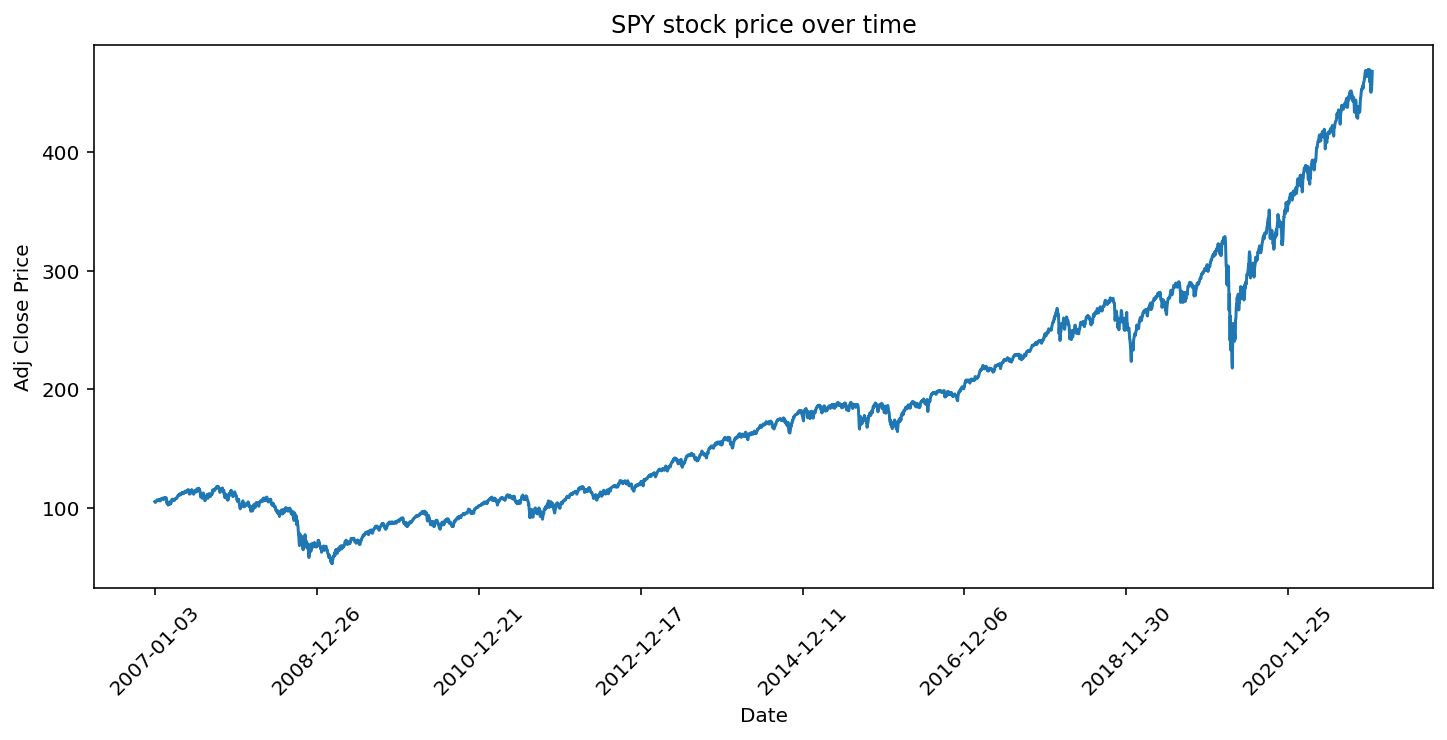

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Adj Close'])
plt.xticks(ticks=date_index, labels=date_list, rotation=45)
plt.title('SPY stock price over time')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.show()

## Auto Regressive Integrated Moving Average (ARIMA) 

The objective of Auto Regressive Integrated Moving Average is to predict a future value based on its own lags and the lagged forecast errors. The algorithm can be divided into three submodels: Auto Regressive (AR), Integrated (I), and Moving Average (MA).

- **Integrated (I)**

    Since ARIMA is a class of linear regression model, this algorithm assumes that the data points in our dataset are uncorrelated and independent of each other. Therefore, we need to make our observations stationary (meaning uncorrelated and independent) by substracting (differencing) the previous value from the current value. The minimum number of differencing required to make the data stationary is denoted by $d$. If the data is already stationary, then $d = 0$.
    
    
- **Auto Regressive (AR)**

   The AR only model uses the linear combination of its weighted predefined number of past observations (lags) added with an intercept value and an error to predict the current observation at time $t$. 
   
    $Y_t = \alpha + \gamma_1Y_{t-1} + \gamma_2Y_{t-2} + ... + \gamma_pY_{t-p} + \epsilon_t$
   
   Here, $p$ is the number of lag observations, $\alpha$ is the intercept, $Y_{t-i}$ is the $i^{th}$ lag of the current observation $(i = 1,...,p)$, $\gamma_i$ is the weight of the $i^{th}$ lag, and $\epsilon_t = |Y_t - (\alpha + \sum_{i=1}^{p}\gamma_iY_{t-i})|$, i.e. the error (norm) between $Y_t$ and its weighted laggs added with the intercept.


- **Moving Average (MA)**

    The MA only model uses the linear combination of its lagged error and weighted lagged forecast errors added with an intercept value to predict the current observation at time $t$. 
    
    $Y_t = \beta + \epsilon_t +\phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} + ... + \phi_q\epsilon_{t-q}$
    
    where $q$ is the size of the moving average window, $\beta$ is the intercept, $\epsilon_{t-i}$ is the $i^{th}$ lag error of the current observation $(i = 1,...,q)$, $\phi_i$ is the weight of the $i^{th}$ lag error. The value of $\epsilon_t$ can be obtained by the same procedure as the one in the AR only model.
    
**ARIMA model**: Data points are differenced until it is stationary then the AR and MA models are combine, resulting in $Y_t$, the predicted value at $t$ as follows:

$Y_t = \kappa + \gamma_1Y_{t-1} + \gamma_2Y_{t-2} + ... + \gamma_pY_{t-p} + \epsilon_t +\phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} + ... + \phi_q\epsilon_{t-q} $

where $\kappa = \alpha + \beta$

## Check for Stationarity

Using the Augmented Dickey–Fuller (ADF) test, we can test whether our dataset is stationary or not. If the P-value is greater than the significant level (0.05), we conclude that the observations are non-stationary.

In [19]:
result = adfuller(df['Adj Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.977091
p-value: 1.000000


Since P-value is greater than the significance level, we now differentiate the data series and find the maximum order of `d`, the order of differencing. 

## Find the maximum order of differencing $d$

Generate the autocorrelation plot and evaluate the maximum value of $d$.

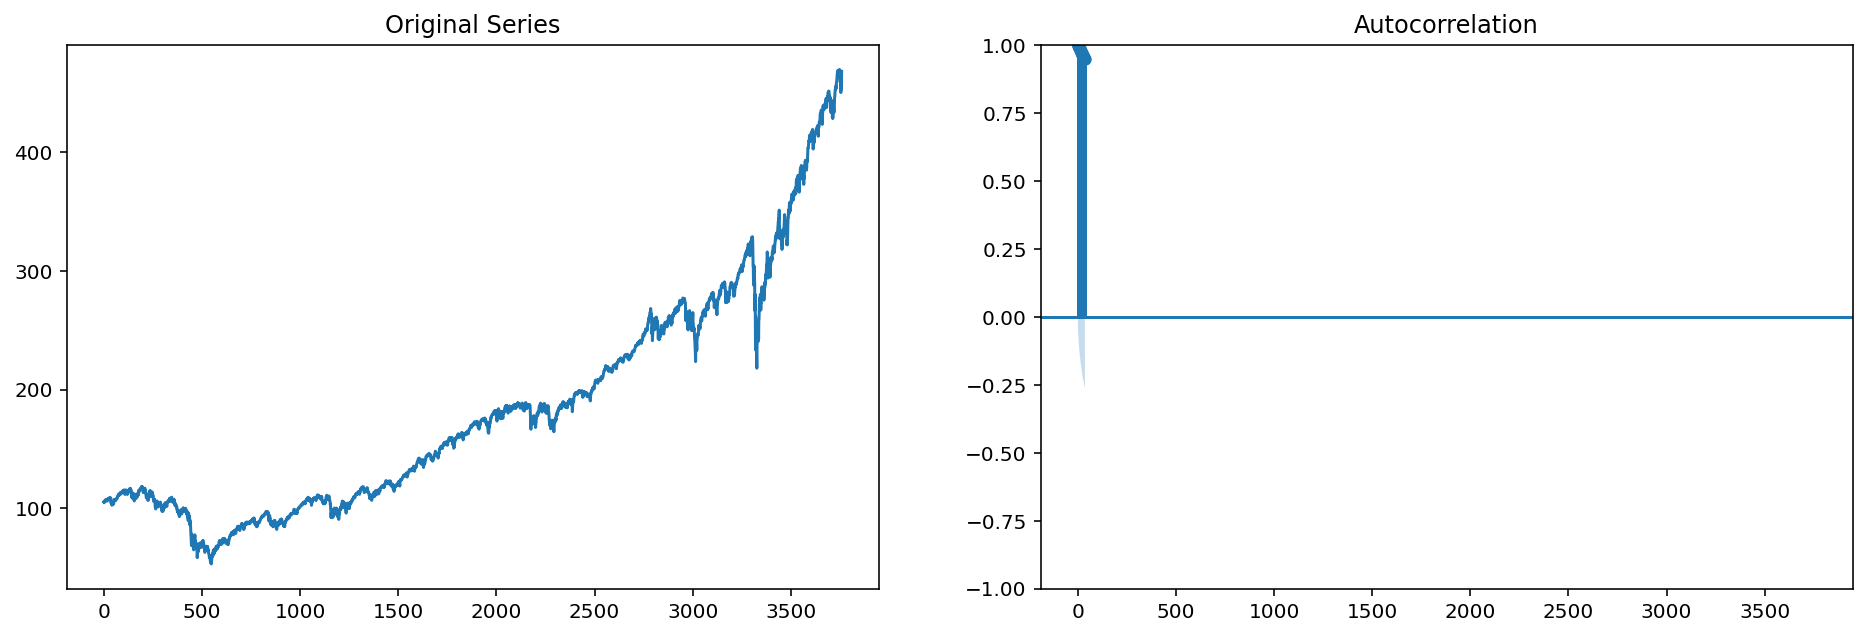

In [37]:
# Original Series
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,5))
axes[0].plot(df['Adj Close']); axes[0].set_title('Original Series')
plot_acf(df['Adj Close'], ax=axes[1])

plt.show()

For visualization, zoom in into the first 50 data points.

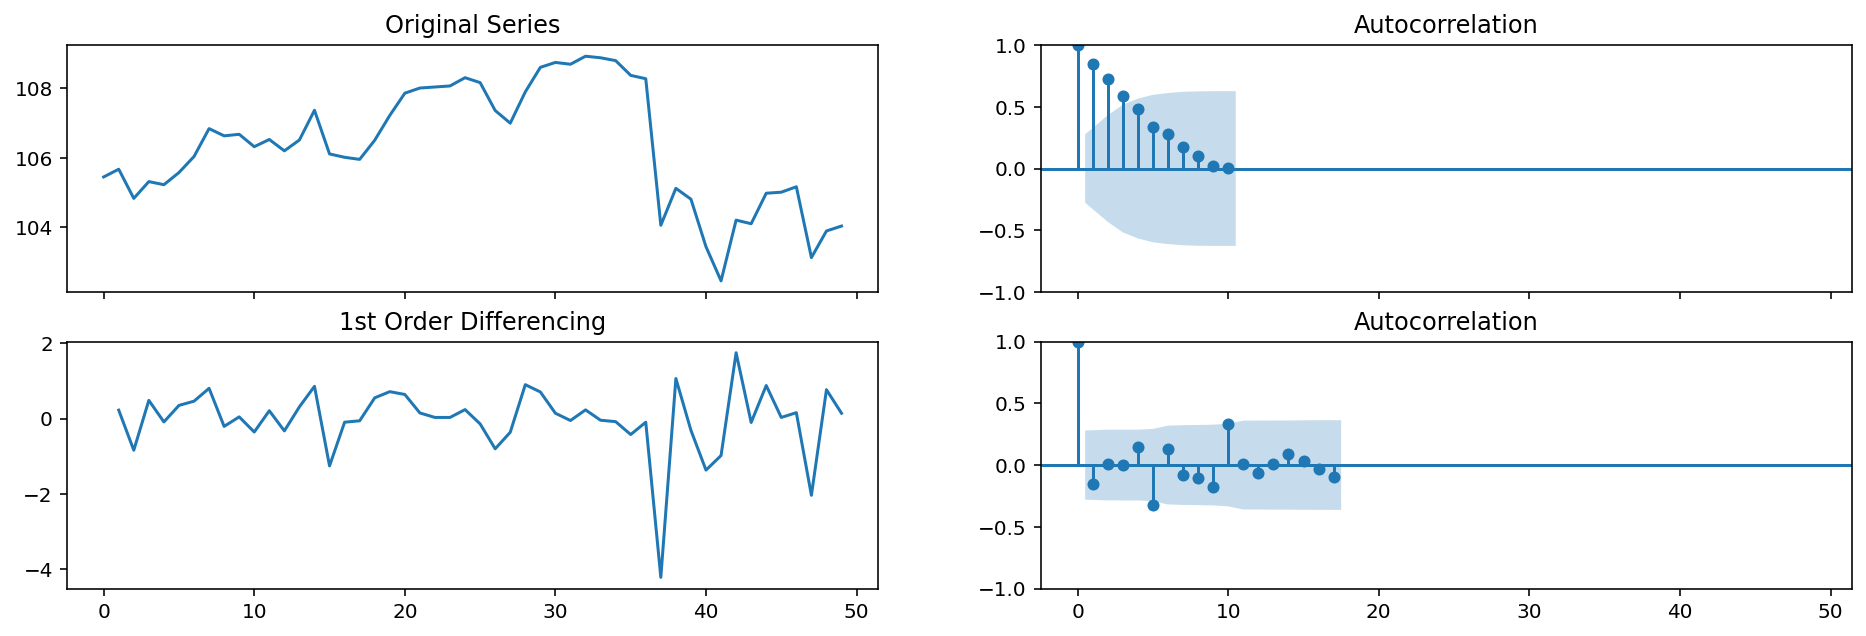

In [38]:
# Original Series
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,5))
axes[0, 0].plot(df['Adj Close'][:50]); axes[0, 0].set_title('Original Series')
plot_acf(df['Adj Close'][:50], ax=axes[0, 1], lags=10)

# 1st Differencing
axes[1, 0].plot(df['Adj Close'][:50].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Adj Close'][:50].diff().dropna(), ax=axes[1, 1])

plt.show()

From the plots above, we see that the data series reaches stationarity with one order of differencing. Therefore, $d_{max} = 1$.

## Find the maximum order of the AR term $p$

Inspect the Partial Autocorrelation (PACF) plot in order to find the order of the AR term $p$. PACF is a measure of the correlation between $k-separated$ data points in a time series (i.e. $Y_t$ and $Y_{t-k}$), after considering the presence of all other shorter lag term in between (i.e. $Y_{t-1},...,Y_{t-k-1}$). 

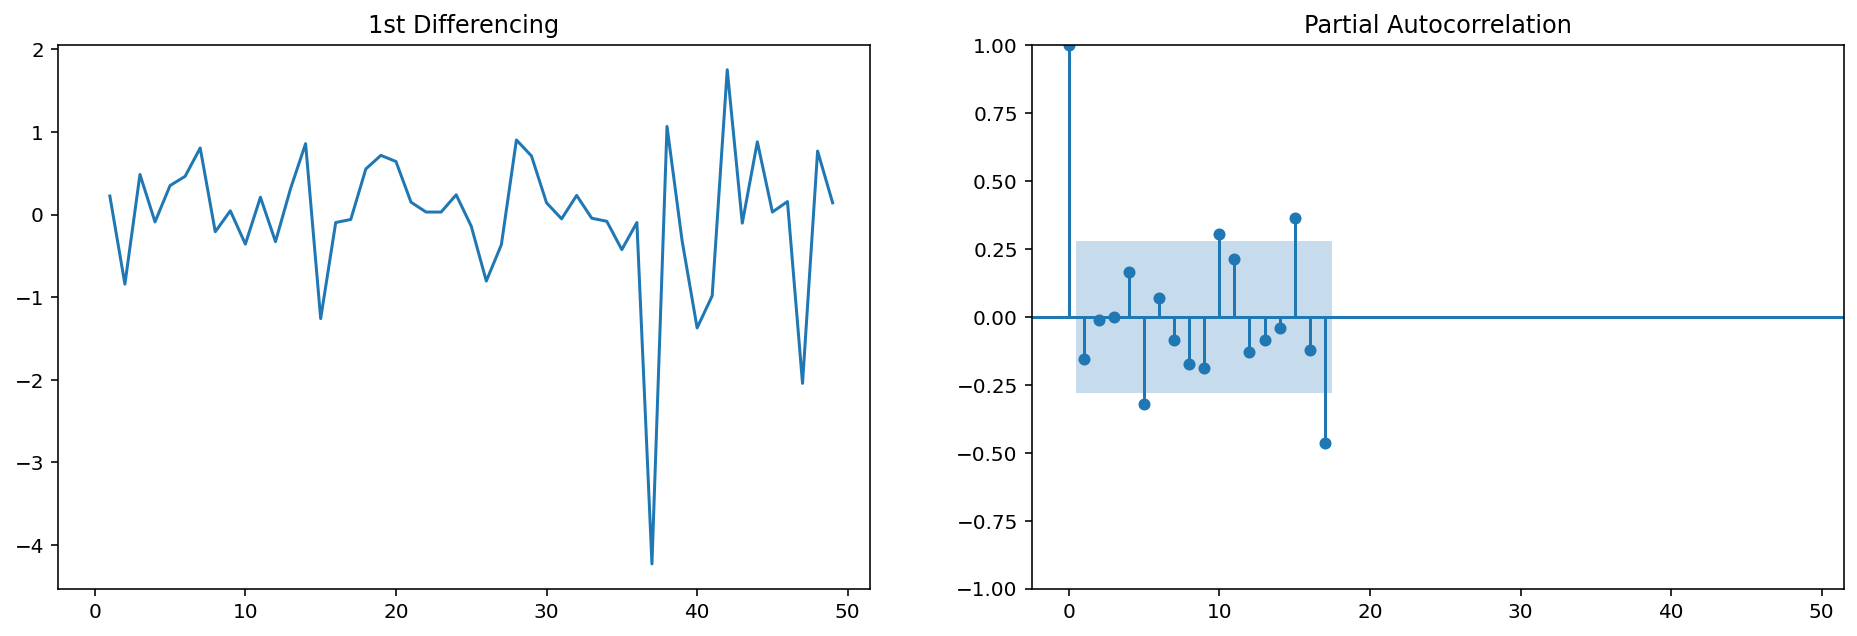

In [39]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,5))
axes[0].plot(df['Adj Close'][:50].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df['Adj Close'][:50].diff().dropna(), ax=axes[1]);

plt.show()

We see that the $6^{th}$ data point lays above the significance line. Therefore, we can choose $p_{max} = 6$.

## Find the maximum order of the MA term $q$

Again, we can look at the ACF plot for the number of MA terms $q$. The number of MA term is the errors of the lagged forecast considered in our model.

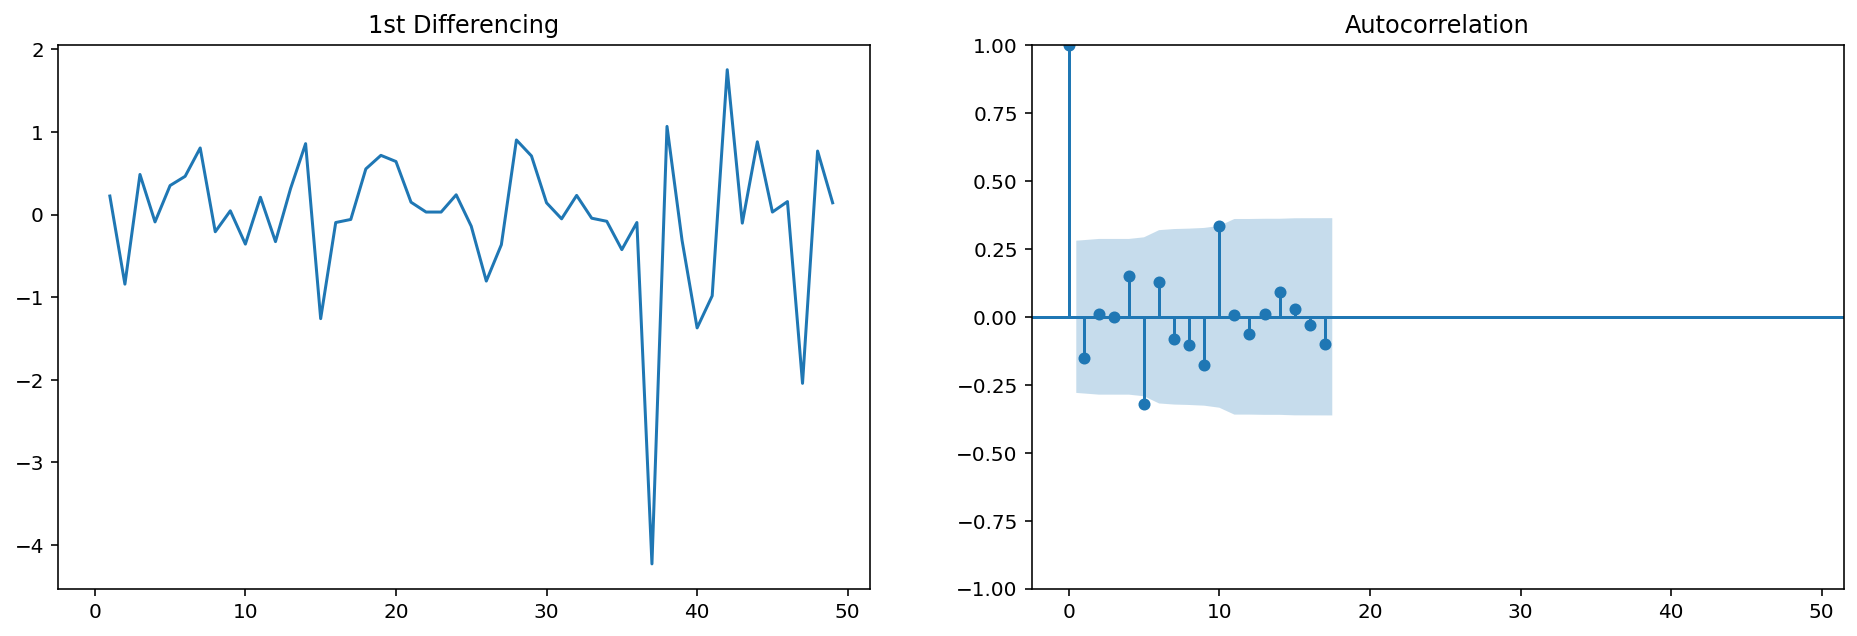

In [40]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,5))
axes[0].plot(df['Adj Close'][:50].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df['Adj Close'][:50].diff().dropna(), ax=axes[1])

plt.show()

We can choose $q_{max} = 5$.

## Find the best combination of hyperparameters $(p,d,q)$ in which produce the best model (has the least AIC)

$70\%$ of the data goes into training set and $30\%$ into test set.

In [43]:
model = pm.auto_arima(df['Adj Close'][0:int(len(df)*0.7)], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8992.096, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9004.921, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8998.552, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8997.773, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9005.945, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8994.084, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8994.083, Time=0.74 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8994.976, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8995.450, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8996.080, Time=0.68 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8994.533, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.897 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2

We will use $(p,d,q) = (1,1,1)$ for our ARIMA model.

## Model Prediction

In [44]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Adj Close'].values
test_data = test_data['Adj Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

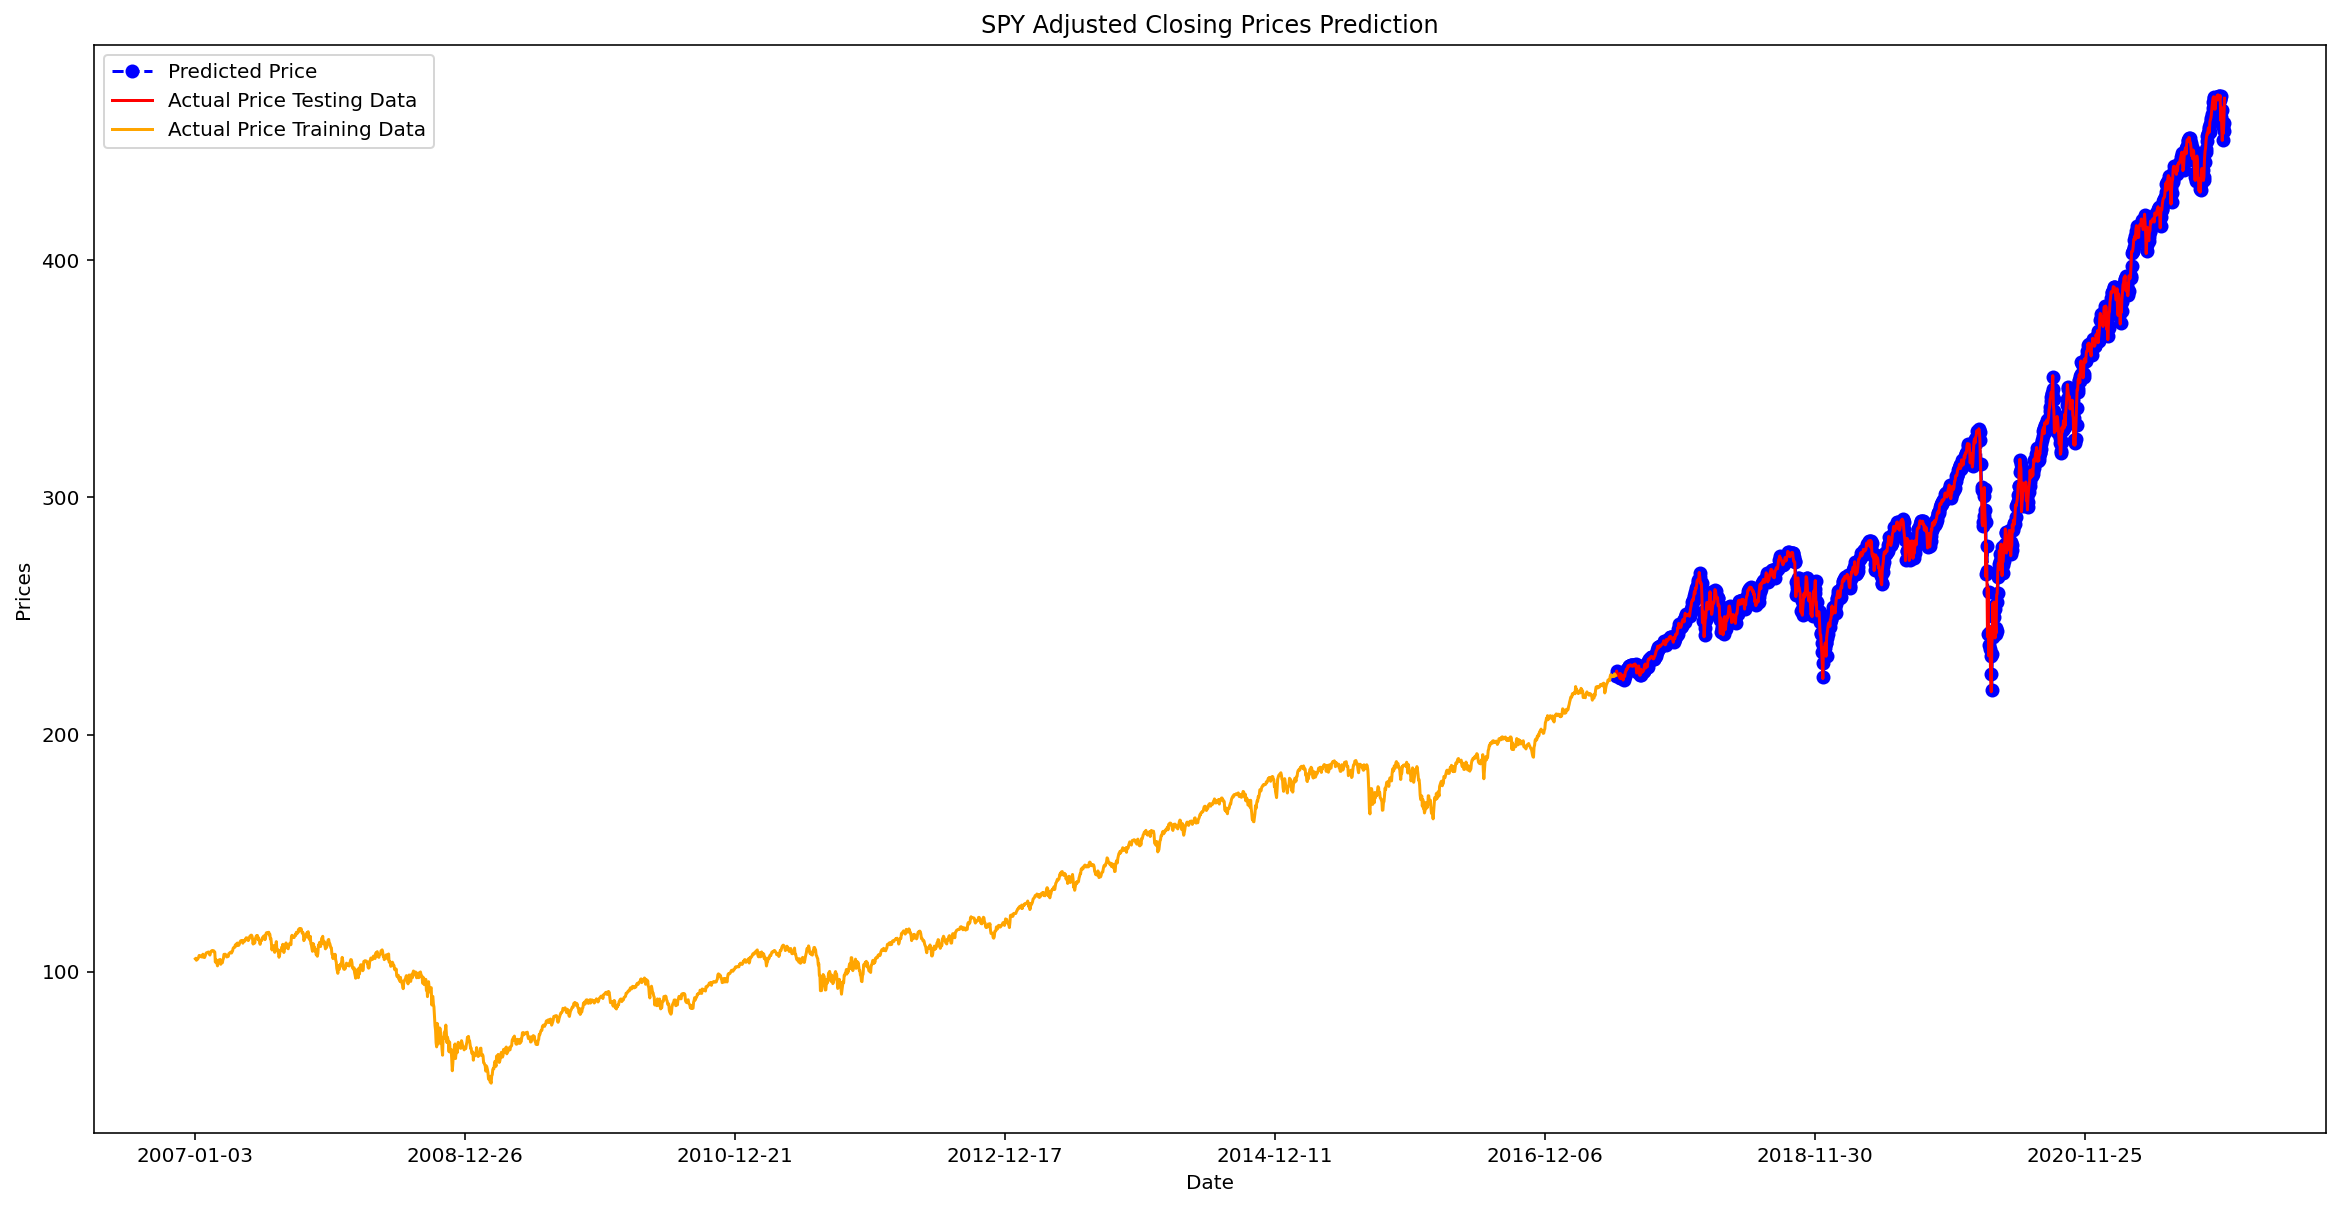

In [45]:
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price Testing Data')
plt.plot(training_data, color='orange', label='Actual Price Training Data')
plt.title('SPY Adjusted Closing Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(ticks=date_index, labels=date_list, rotation=0)
plt.legend()
plt.show()

In [46]:
MAE_error = mean_absolute_error(test_data, model_predictions)
print('Testing Mean Absolute Error is {}'.format(MAE_error))

Testing Mean Absolute Error is 2.2543826558826217


### Predicting Tomorrow's Adjusted Closing Price

In [47]:
model = ARIMA(history, order=(6,1,2))
model_fit = model.fit()
output = model_fit.forecast()
yhat = output[0]
print('Tomorrow\'s Adjusted Closing Price: ${:.2f}'.format(yhat))

Tomorrow's Adjusted Closing Price: $468.97
